WeGo Public Transit

WeGo Public Transit is a public transit system serving the Greater Nashville and Davidson County area. WeGo provides local and regional bus routes, the WeGo Star train service connecting Lebanon to downtown Nashville, along with several other transit services.

The data for this project can be downloaded from here.

In this project, you'll be analyzing the on-time performance of buses to look for patterns and try to identify correlations to controllable or external factors.

The main variable you will be studying in this project is adherence, which compares the actual departure time to the scheduled time and is included in the ADHERENCE column. A negative adherence value means that a bus left a time point late and a positive adherence indicates that the bus left the time point early. Buses with adherence values beyond negative 6 are generally considered late and beyond positive 1 are considered early. However, there is some additional logic where the staff applies waivers to allow early departures, such as an express bus that has already picked up everyone at a park-and-ride lot and is only dropping people off at the remaining stops, and also allows for early timepoint records for all records where TRIP_EDGE = 2 (end of trip), since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. Note: When determining whether a bus is early or late, it is advised that you use the 'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', and 'ADJUSTED_ONTIME_COUNT' columns in order to account for the adjustments.

In [30]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in file
wego_df = pd.read_csv('../grp_proj_data/Headway Data, 8-1-2023 to 9-30-2023.csv')

# Check df
wego_df

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,0.000000,NaN
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,NaN,0,1,0,0,NaN,0,0.000000,NaN
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,0.000000,NaN
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,47.500000,17.500000,0,1,0,0,0.0,0,0.000000,NaN


In [3]:
# Convert columns to datetime
wego_df['DATE'] = pd.to_datetime(wego_df['DATE'], errors='coerce')
wego_df['SCHEDULED_TIME'] = pd.to_datetime(wego_df['SCHEDULED_TIME'], errors='coerce')
wego_df['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(wego_df['ACTUAL_ARRIVAL_TIME'], errors='coerce')
wego_df['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(wego_df['ACTUAL_DEPARTURE_TIME'], errors='coerce')

# Check df
wego_df

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,0.000000,NaN
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,NaN,0,1,0,0,NaN,0,0.000000,NaN
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,0.000000,NaN
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,47.500000,17.500000,0,1,0,0,0.0,0,0.000000,NaN


Goals of this project:

1. What is the overall on-time performance, and what do the overall distribution of adherence look like?

In [4]:
# Use adherence column to see bus performance. Negative=late, Positive=early, 0=ontime
wego_df['ADHERENCE'].describe()

count    338861.000000
mean         -3.188796
std           6.898842
min        -948.533333
25%          -4.566666
50%          -2.000000
75%          -0.333333
max          88.383333
Name: ADHERENCE, dtype: float64

In [5]:
# Calculate overall performance (on time, early and late percentages)
total = len(wego_df)
on_time = wego_df['ADJUSTED_ONTIME_COUNT'].sum()
late = wego_df['ADJUSTED_LATE_COUNT'].sum()
early = wego_df['ADJUSTED_EARLY_COUNT'].sum()

# Check result
print(f'On-time: {(on_time/total)*100:.2f}%')
print(f'Late: {(late/total)*100:.2f}%')
print(f'Early: {(early/total)*100:.2f}%')

On-time: 77.08%
Late: 16.85%
Early: 2.79%


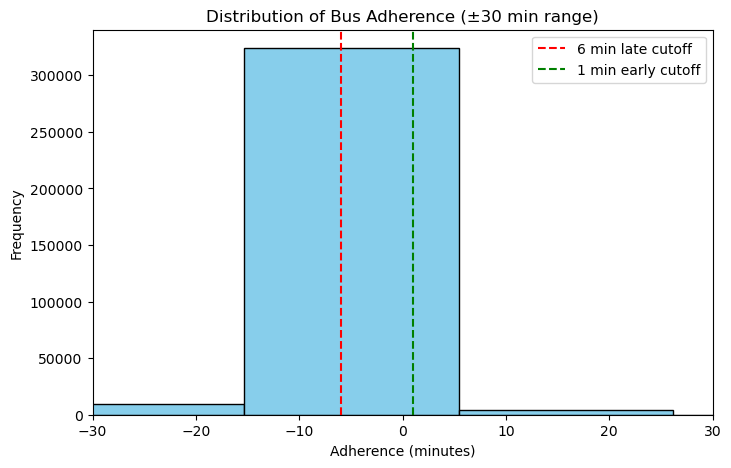

In [6]:
# Visualize adherence with histograph. This will show where buses fall in relation to 'on time window'
plt.figure(figsize=(8,5))
plt.hist(wego_df['ADHERENCE'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Bus Adherence (±30 min range)')
plt.xlabel('Adherence (minutes)')
plt.ylabel('Frequency')
plt.axvline(x=-6, color='red', linestyle='--', label='6 min late cutoff')
plt.axvline(x=1, color='green', linestyle='--', label='1 min early cutoff')

# Focus on normal range of 30 min early to 30 min late (removing outliers)
plt.xlim(-30, 30)

plt.legend()
plt.show()

2. How does direction of travel, route, or location affect the on-time performance?

In [7]:
# On time performance by direction of travel #

# Group data by route direction and sum up each adjusted count
direction_perf = wego_df.groupby('ROUTE_DIRECTION_NAME')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()

# Calculate percentages for each direction
direction_perf['Total'] = direction_perf.sum(axis=1)
direction_perf['% On-Time'] = (direction_perf['ADJUSTED_ONTIME_COUNT'] / direction_perf['Total']) * 100
direction_perf['% Late'] = (direction_perf['ADJUSTED_LATE_COUNT'] / direction_perf['Total']) * 100
direction_perf['% Early'] = (direction_perf['ADJUSTED_EARLY_COUNT'] / direction_perf['Total']) * 100

# Check result
direction_perf[['% On-Time', '% Late', '% Early']]

,% On-Time,% Late,% Early
ROUTE_DIRECTION_NAME,,,
FROM DOWNTOWN,74.963470,22.085708,2.950822
TO DOWNTOWN,85.007678,12.182006,2.810316


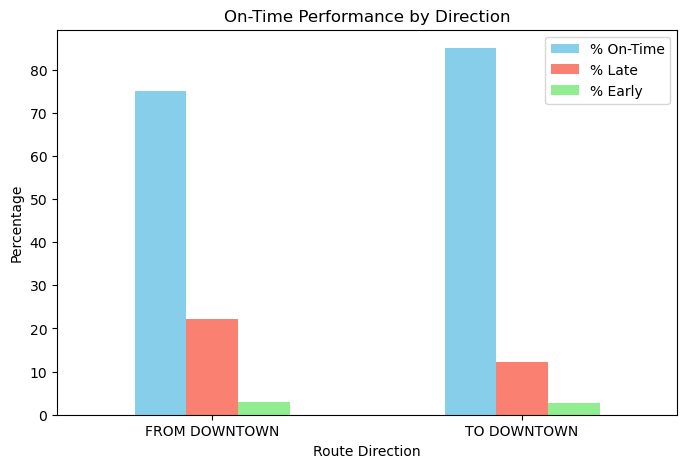

In [8]:
# Visualize with barchart
direction_perf[['% On-Time', '% Late', '% Early']].plot(
    kind='bar',
    figsize=(8,5),
    color=['skyblue', 'salmon', 'lightgreen'],
    title='On-Time Performance by Direction'
)
plt.xlabel('Route Direction')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [9]:
# On-time perfomance by route #

# Group by route and sum up adjusted counts
route_perf = wego_df.groupby('ROUTE_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()

# Calculate percentages
route_perf['Total'] = route_perf.sum(axis=1)
route_perf['% On-Time'] = (route_perf['ADJUSTED_ONTIME_COUNT'] / route_perf['Total']) * 100

# Sort routes from best to worst
route_perf_sorted = route_perf.sort_values('% On-Time', ascending=False)

# Check result
route_perf_sorted

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,Total,% On-Time
ROUTE_ABBR,,,,,
22,22492,2065,631,25188,89.296490
23,35137,3230,1286,39653,88.611202
50,36309,5113,1207,42629,85.174412
56,48361,8837,1752,58950,82.037320
7,13417,3417,433,17267,77.703133
52,37736,10038,1553,49327,76.501713
3,34516,9590,1382,45488,75.879353
55,42080,16748,1531,60359,69.716198


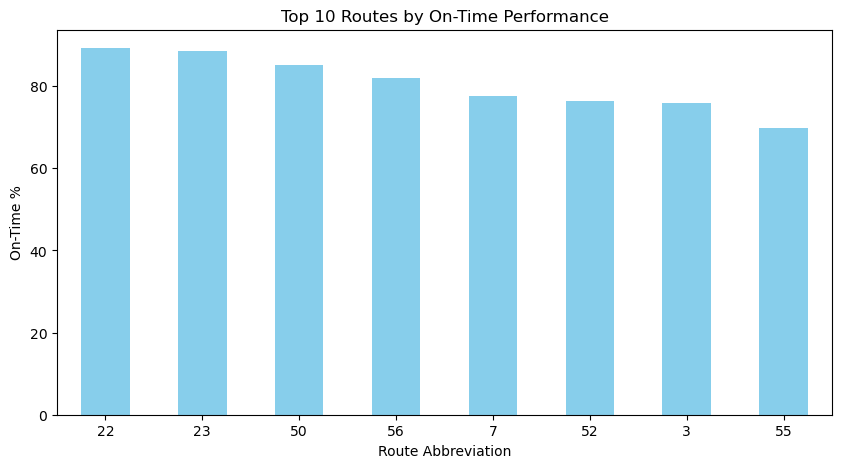

In [10]:
# Plot top 10 best performing routes
route_perf_sorted['% On-Time'].plot(kind='bar', color='skyblue', figsize=(10,5), title='Top 10 Routes by On-Time Performance')
plt.xlabel('Route Abbreviation')
plt.ylabel('On-Time %')
plt.xticks(rotation=0)
plt.show()

In [11]:
# On-time performance by location (time points) #

# Group by timepoint
stop_perf = wego_df.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()

# Calculate percentages
stop_perf['Total'] = stop_perf.sum(axis=1)
stop_perf['% On-Time'] = (stop_perf['ADJUSTED_ONTIME_COUNT'] / stop_perf['Total']) * 100

# Sort on-time percentage from best to worst
stop_perf_sorted = stop_perf.sort_values('% On-Time', ascending=False)

# Check result
stop_perf_sorted.head

<bound method NDFrame.head of                  ADJUSTED_ONTIME_COUNT  ADJUSTED_LATE_COUNT  \
TIME_POINT_ABBR                                               
MCC5_6                             115                    1   
25ACLARK                          2335                   38   
MCC5_10                           7025                  310   
MCC4_24                           7603                  364   
MEIG                                97                    5   
...                                ...                  ...   
HEAD                                37                    3   
MCC5_12                             16                   23   
MCC5_11                             21                   49   
MCC4_13                             19                    3   
MCC5_7                               2                   31   

                 ADJUSTED_EARLY_COUNT  Total  % On-Time  
TIME_POINT_ABBR                                          
MCC5_6                            

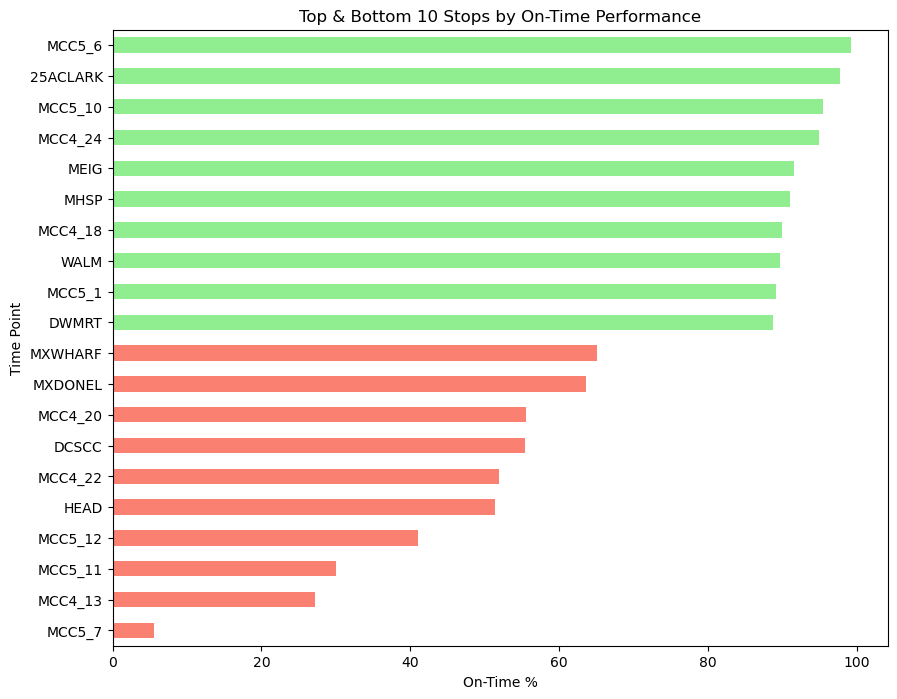

In [12]:
# Top 10 on-time stops
top_stops = stop_perf_sorted.head(10)

# Bottom 10 on-time stops
bottom_stops = stop_perf_sorted.tail(10)

# Combine top and bottom into one table
top_bottom = pd.concat([top_stops, bottom_stops])

top_bottom['% On-Time'].plot(
    kind='barh',
    color=['lightgreen']*10 + ['salmon']*10,
    figsize=(10,8),
    title='Top & Bottom 10 Stops by On-Time Performance'
)
plt.xlabel('On-Time %')
plt.ylabel('Time Point')
plt.gca().invert_yaxis()  # Optional: show highest on top
plt.show()

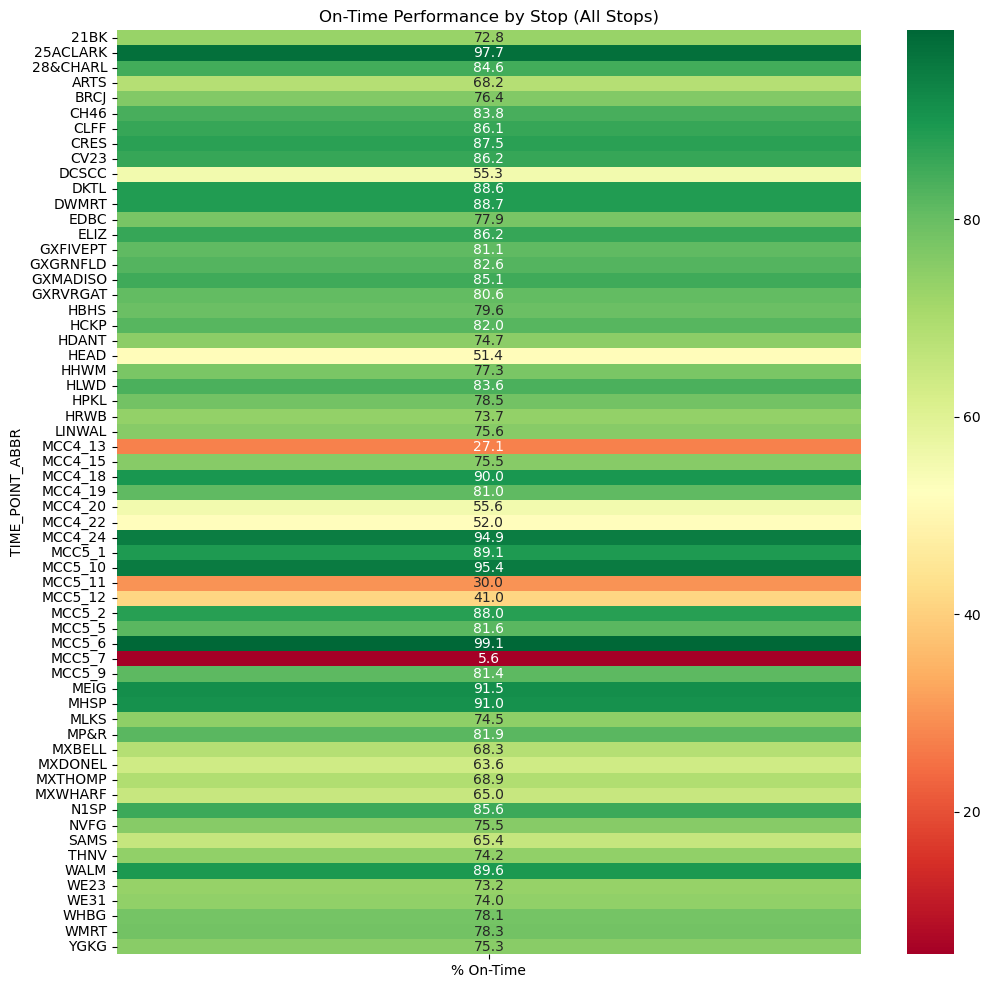

In [13]:
import seaborn as sns

# Sort stops alphabetically
stop_perf_sorted_heatmap = stop_perf_sorted.sort_index()

plt.figure(figsize=(12,12))
sns.heatmap(stop_perf_sorted_heatmap[['% On-Time']], cmap='RdYlGn', annot=True, fmt=".1f")
plt.title('On-Time Performance by Stop (All Stops)')
plt.show()

3. How does time of day or day of week affect on-time performance?

In [14]:
# Create new columns to add to wego_df #

# Day of week
wego_df['DAY_OF_WEEK'] = wego_df['SCHEDULED_TIME'].dt.day_name()

# Hour of day
wego_df['HOUR_OF_DAY'] = wego_df['SCHEDULED_TIME'].dt.hour

# Check new columns
wego_df[['SCHEDULED_TIME', 'DAY_OF_WEEK', 'HOUR_OF_DAY']].head

<bound method NDFrame.head of             SCHEDULED_TIME DAY_OF_WEEK  HOUR_OF_DAY
0      2023-08-01 04:42:00     Tuesday            4
1      2023-08-01 04:46:00     Tuesday            4
2      2023-08-01 04:54:00     Tuesday            4
3      2023-08-01 05:10:00     Tuesday            5
4      2023-08-01 05:15:00     Tuesday            5
...                    ...         ...          ...
350324 2023-09-30 22:23:00    Saturday           22
350325 2023-09-30 22:38:00    Saturday           22
350326 2023-09-30 22:45:00    Saturday           22
350327 2023-09-30 22:59:00    Saturday           22
350328 2023-09-30 23:11:00    Saturday           23

[350329 rows x 3 columns]>

In [15]:
# On-time performance by hour of day #

# Group by hour
hour_perf = wego_df.groupby('HOUR_OF_DAY')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()

# Calculate total and on-time percentage
hour_perf['Total'] = hour_perf.sum(axis=1)
hour_perf['% On-Time'] = (hour_perf['ADJUSTED_ONTIME_COUNT'] / hour_perf['Total']) * 100

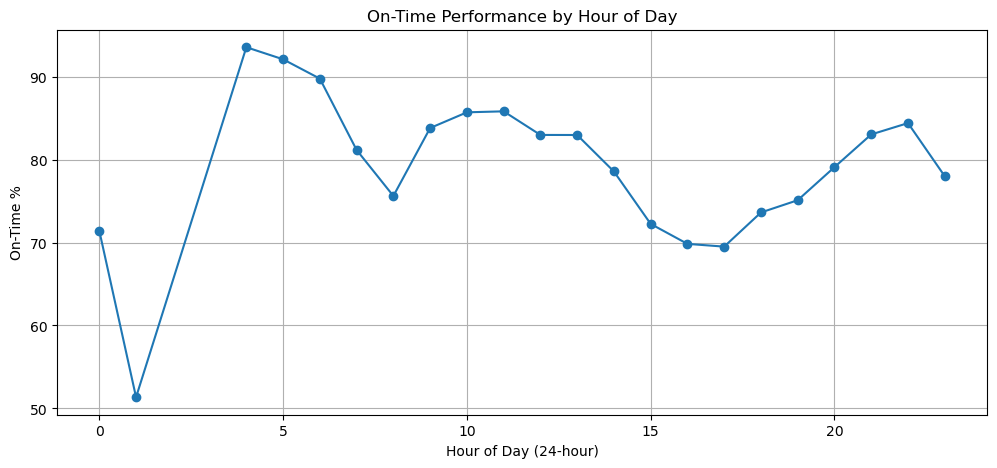

In [16]:
# Plot performance by hour of day
hour_perf['% On-Time'].plot(
    kind='line',
    figsize=(12,5),
    marker='o',
    title='On-Time Performance by Hour of Day'
)
plt.xlabel('Hour of Day (24-hour)')
plt.ylabel('On-Time %')
plt.grid(True)
plt.show()

In [17]:
# On-time performance by day of week #

# Group by day of week
dow_perf = wego_df.groupby('DAY_OF_WEEK')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()

# Calculate total and percentages
dow_perf['Total'] = dow_perf.sum(axis=1)
dow_perf['% On-Time'] = (dow_perf['ADJUSTED_ONTIME_COUNT'] / dow_perf['Total']) * 100
dow_perf['% Late'] = (dow_perf['ADJUSTED_LATE_COUNT'] / dow_perf['Total']) * 100
dow_perf['% Early'] = (dow_perf['ADJUSTED_EARLY_COUNT'] / dow_perf['Total']) * 100

# Sort days in calendar order
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_perf = dow_perf.reindex(dow_order)

# Show result
dow_perf[['% On-Time', '% Late', '% Early']]

,% On-Time,% Late,% Early
DAY_OF_WEEK,,,
Monday,84.002192,12.623303,3.374505
Tuesday,80.152550,16.909441,2.938009
Wednesday,79.009960,18.103887,2.886152
Thursday,78.292315,18.910706,2.796979
Friday,75.502504,21.650572,2.846924
Saturday,79.444170,18.357726,2.198103
Sunday,84.169752,12.748526,3.081722


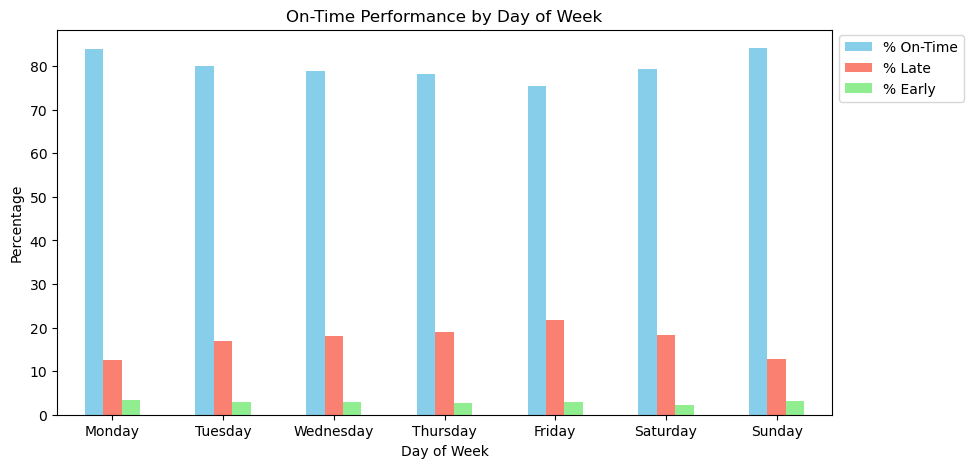

In [18]:
# Visualize with barchart
dow_perf[['% On-Time', '% Late', '% Early']].plot(
    kind='bar',
    figsize=(10,5),
    color=['skyblue','salmon','lightgreen'],
    title='On-Time Performance by Day of Week'
)
plt.xlabel('Day of Week')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))
plt.show()

4. How much of a factor does the driver have on on-time performance? The driver is indicated by the OPERATOR variable.

In [19]:
# Group by driver/operator
driver_perf = wego_df.groupby('OPERATOR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()

# Calculate total and percentages
driver_perf['Total'] = driver_perf.sum(axis=1)
driver_perf['% On-Time'] = (driver_perf['ADJUSTED_ONTIME_COUNT'] / driver_perf['Total']) * 100
driver_perf['% Late'] = (driver_perf['ADJUSTED_LATE_COUNT'] / driver_perf['Total']) * 100
driver_perf['% Early'] = (driver_perf['ADJUSTED_EARLY_COUNT'] / driver_perf['Total']) * 100

# Sort by best on-time performance
driver_perf_sorted = driver_perf.sort_values('% On-Time', ascending=False)

# Show top and bottom drivers
driver_perf_sorted.head(10), driver_perf_sorted.tail(10)

(          ADJUSTED_ONTIME_COUNT  ADJUSTED_LATE_COUNT  ADJUSTED_EARLY_COUNT  \
 OPERATOR                                                                     
 0                             1                    0                     0   
 56                            3                    0                     0   
 2294                         45                    0                     0   
 1762                       2294                   23                    16   
 1706                         43                    0                     1   
 1597                        252                    6                     0   
 2639                        202                    2                     3   
 2573                        400                   12                     0   
 409                        2310                   61                     9   
 1566                       2135                   48                    17   
 
           Total   % On-Time    % Late   % Early  

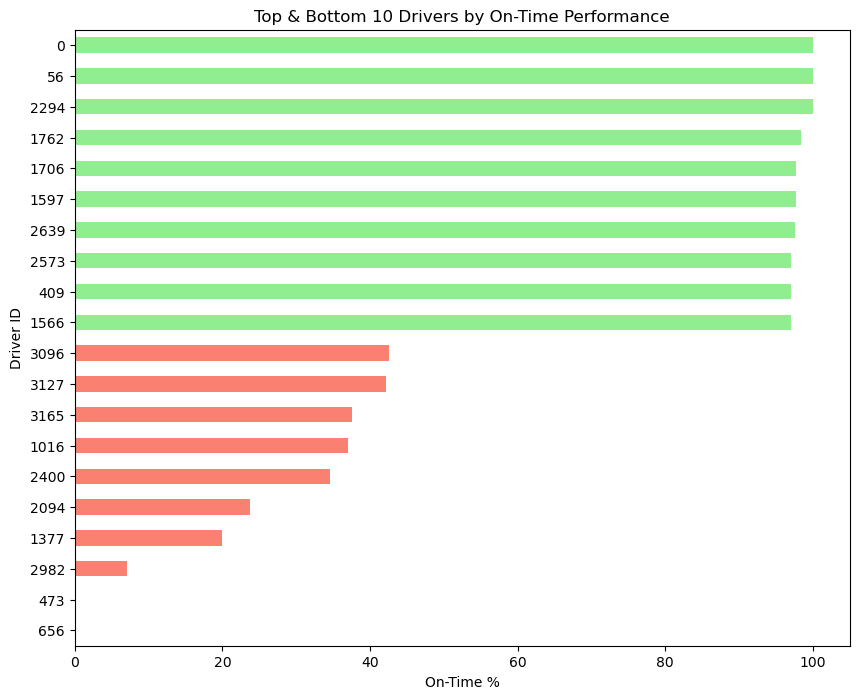

In [20]:
# Top 10 and bottom 10 drivers
top_drivers = driver_perf_sorted.head(10)
bottom_drivers = driver_perf_sorted.tail(10)

# Combine for plotting
top_bottom_drivers = pd.concat([top_drivers, bottom_drivers])

# Horizontal bar chart
top_bottom_drivers['% On-Time'].plot(
    kind='barh',
    color=['lightgreen']*10 + ['salmon']*10,
    figsize=(10,8),
    title='Top & Bottom 10 Drivers by On-Time Performance'
)
plt.xlabel('On-Time %')
plt.ylabel('Driver ID')
plt.gca().invert_yaxis()  # optional: highest on top
plt.show()

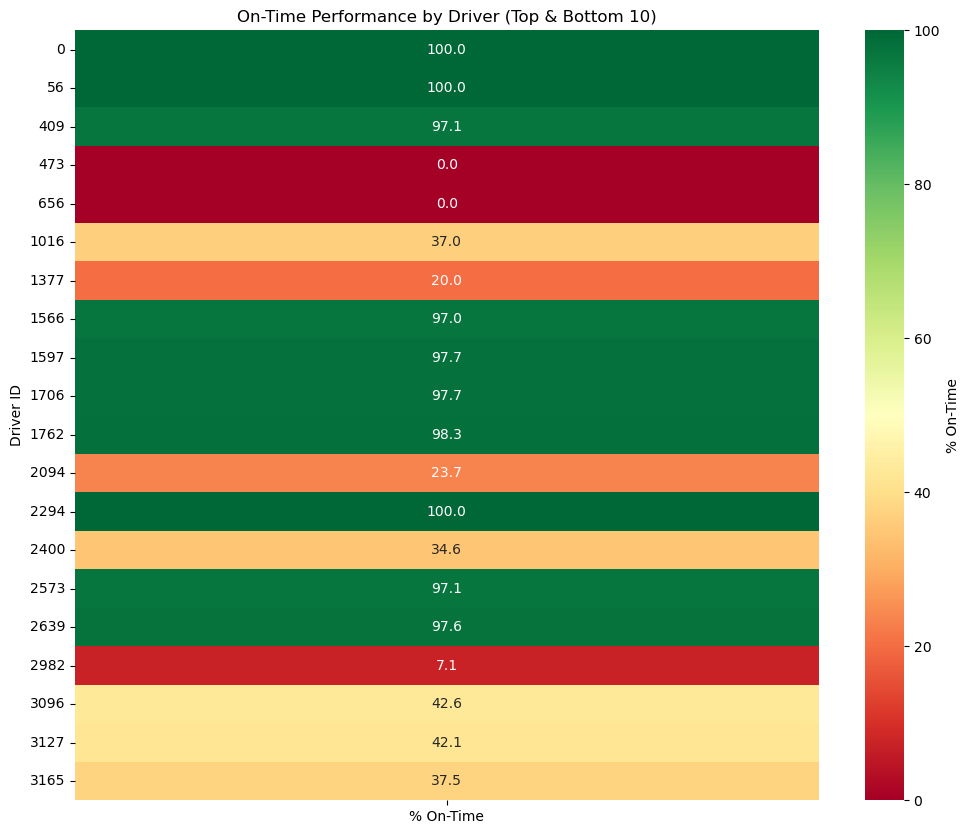

In [43]:
# Sort drivers by % On-Time
#driver_perf_sorted_heatmap = driver_perf.sort_values()

plt.figure(figsize=(12,10))  # smaller figure since only 20 drivers
sns.heatmap(top_bottom_drivers.sort_index()[['% On-Time']], 
            cmap='RdYlGn',     # red=low, green=high
            annot=True,        # show numbers
            fmt=".1f",         # one decimal place
            cbar_kws={'label': '% On-Time'})
plt.title('On-Time Performance by Driver (Top & Bottom 10)')
plt.ylabel('Driver ID')
plt.yticks(rotation=0)
plt.show()

5. Is there any relationship between lateness (ADHERENCE) and headway deviation? The headway deviation variable is contained in the HDWY_DEV column. See the notes under number 9 for a description of headway and headway deviation.

In [24]:
# Create a dataframe for analysis
headway_df = wego_df[['ADHERENCE', 'SCHEDULED_HDWY', 'HDWY_DEV']].dropna()

# Filter out rows where scheduled hdwy is 0 or negative
headway_df = headway_df[headway_df['SCHEDULED_HDWY'] > 0]

# Calculate headway deviation as a percent of scheduled headway
headway_df['HDWY_DEV_PCT'] = (headway_df['HDWY_DEV'] / headway_df['SCHEDULED_HDWY']) * 100

# Check result
headway_df.head()

,ADHERENCE,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PCT
7,-1.716666,35.0,2.666666,7.619046
8,-1.916666,35.0,1.966666,5.619046
9,-0.183333,15.0,-0.483334,-3.222227
11,-1.316666,15.0,-2.166667,-14.444447
12,1.500000,15.0,-3.883334,-25.888893


In [25]:
# Summary stats
headway_df.describe()

,ADHERENCE,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PCT
count,265847.000000,265847.000000,265847.000000,265847.000000
mean,-3.503547,18.107727,0.517809,3.162491
std,6.501571,11.906045,7.162202,46.666770
min,-948.533333,2.000000,-64.000000,-100.000000
25%,-4.616666,10.000000,-2.316667,-14.166667
50%,-2.216666,15.000000,0.033333,0.175437
75%,-0.666666,20.000000,2.483333,15.500000
max,85.666666,503.000000,565.433333,2417.500000


In [34]:
# Correlation analysis
corr = headway_df['ADHERENCE'].corr(headway_df['HDWY_DEV_PCT'])
print(f"Correlation between Adherence and Headway Deviation %: {corr:.3f}")

Correlation between Adherence and Headway Deviation %: -0.204


Corr Value	Interpretation

+0.7 to +1.0	Strong positive relationship (late buses cause big gaps)

+0.3 to +0.6	Moderate positive relationship (typical pattern)

0	No strong relationship

-0.3 to -1.0	Negative relationship (rare — would mean early buses are causing gaps)

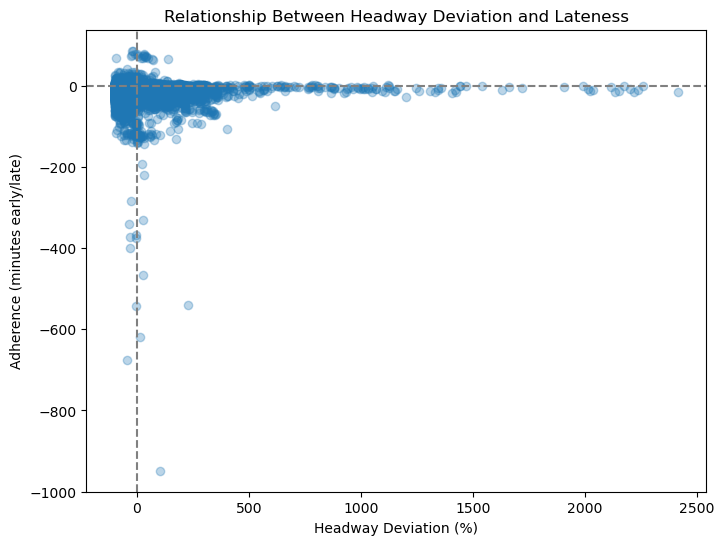

In [ ]:
# Scatterplot visualization
plt.figure(figsize=(8,6))
plt.scatter(headway_df['HDWY_DEV_PCT'], headway_df['ADHERENCE'], alpha=0.3)
plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Headway Deviation (%)')
plt.ylabel('Adherence (minutes early/late)')
plt.title('Relationship Between Headway Deviation and Lateness')
plt.show()

# Explanation:
# Each dot = one observation (a bus stop event).
# Vertical line (0%) = perfect spacing;
# Horizontal line (0 minutes) = on time.
# Clusters in upper-right show late & gapped buses;
# lower-left shows early & bunched buses.

In [31]:
# Flag acceptable headways
headway_df['HDWY_STATUS'] = np.where(
    (headway_df['HDWY_DEV_PCT'] >= 50) & (headway_df['HDWY_DEV_PCT'] <= 150),
    'Acceptable',
    'Out of Range'
)

# Check proportions
headway_df['HDWY_STATUS'].value_counts(normalize=True) * 100

HDWY_STATUS
Out of Range    92.474619
Acceptable       7.525381
Name: proportion, dtype: float64

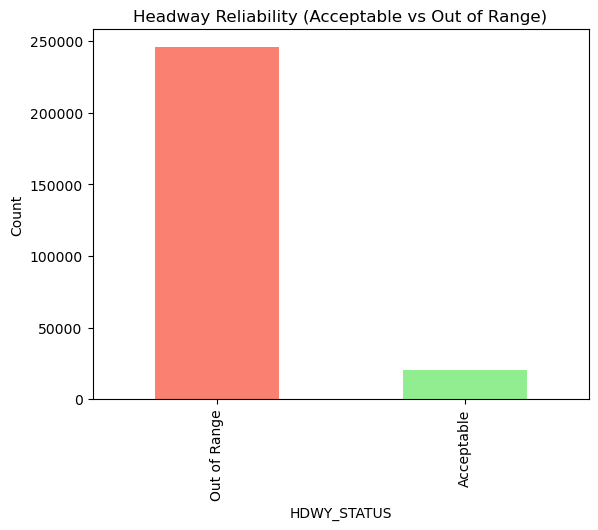

In [38]:
# Barchart visualizaiton
headway_df['HDWY_STATUS'].value_counts().plot(
    kind='bar',
    color=['salmon', 'lightgreen'],
    title='Headway Reliability (Acceptable vs Out of Range)'
)
plt.ylabel('Count')
plt.show()

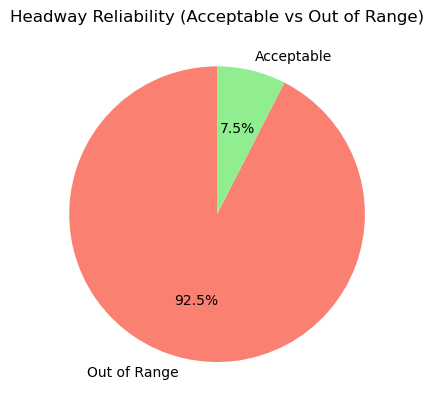

In [39]:
headway_df['HDWY_STATUS'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['salmon', 'lightgreen'],
    startangle=90,
    title='Headway Reliability (Acceptable vs Out of Range)'
)
plt.ylabel('')
plt.show()

Headway reliability appears to be a major factor affecting on-time performance.
Over 92% of observed headways fall outside the acceptable 50–150% range, meaning buses are rarely evenly spaced.
The correlation between lateness (Adherence) and headway deviation percentage is -0.204, indicating a weak but negative relationship. As headways increase (gaps form), buses tend to arrive later, while shorter headways (bunching) often correspond with early arrivals.
This suggests that irregular headway spacing contributes to overall schedule unreliability, and managing headway consistency may improve both adherence and passenger experience.

Stretch Goals:

6. How much impact does being late or too spaced out at the first stop have downstream?

In [47]:
# Get the first stop for each trip
first_stops = wego_df.sort_values(['TRIP_ID', 'ROUTE_STOP_SEQUENCE']).groupby('TRIP_ID').first().reset_index()

# Keep key columns and rename for clarity
first_stops = first_stops[['TRIP_ID', 'ADHERENCE', 'HDWY_DEV', 'SCHEDULED_HDWY']]
first_stops.rename(columns={'ADHERENCE': 'FIRST_STOP_ADHERENCE', 'HDWY_DEV': 'FIRST_STOP_HDWY_DEV'}, inplace=True)

# Handle missing values
first_stops = first_stops.dropna(subset=['FIRST_STOP_ADHERENCE', 'FIRST_STOP_HDWY_DEV', 'SCHEDULED_HDWY'])
first_stops

,TRIP_ID,FIRST_STOP_ADHERENCE,FIRST_STOP_HDWY_DEV,SCHEDULED_HDWY
2,345106,4.483333,-0.483334,15.0
3,345107,-1.316666,-2.166667,15.0
4,345108,4.183333,2.716666,15.0
5,345109,-1.733333,0.233333,15.0
6,345110,4.483333,1.000000,15.0
...,...,...,...,...
3978,353532,-0.900000,-4.733334,17.0
3979,353533,-2.450000,2.000000,15.0
3983,353988,2.266666,11.416666,0.0
3985,354098,-17.933333,-9.516667,10.0


7. What is the impact of the layover at the start of the trip (the difference between the first stop arrival and departure time)? Does more dwell time at the beginning of a trip lead to more stable headways (lower values for % headway deviation)? Do trips with longer scheduled layover time have more stable headway values?

8. What is the relationship between distance or time traveled since the start of a given trip and the adherence value? Does on-time performance become less stable the further along the route the bus has traveled?

9. Headway is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop. This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. Bunching occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. Gapping is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal). How do the variables studied related to headway deviation?